# Reinforcement Learning - A Survey

## Environment

In [1]:
import gymnasium as gym
import numpy as np
from IPython import display
from time import sleep
import matplotlib.pyplot as plt

### A simple environment : Cliffwalking

In [2]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")

#### State and Actions

In [4]:
env.observation_space

Discrete(48)

In [3]:
env.action_space

Discrete(4)

#### What is inside ?

In [7]:
env.reset()

(36, {'prob': 1})

In [8]:
env.s

36

In [9]:
env.step(1)

(36, -100, False, False, {'prob': 1.0})

(-0.5, 719.5, 239.5, -0.5)

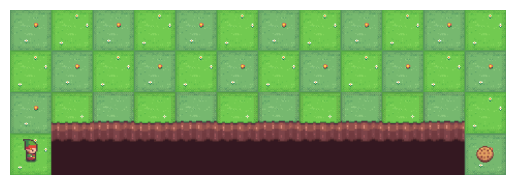

In [10]:
plt.imshow(env.render())
plt.axis('off')

(-0.5, 719.5, 239.5, -0.5)

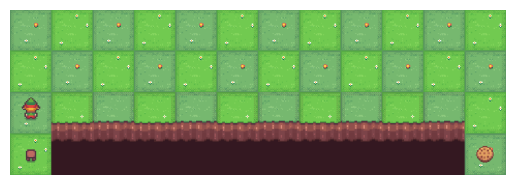

In [15]:
env.step(0)
plt.imshow(env.render())
plt.axis('off')

#### MDP?

In [16]:
env.P[35]

{0: [(1.0, 23, -1, False)],
 1: [(1.0, 35, -1, False)],
 2: [(1.0, 47, -1, True)],
 3: [(1.0, 34, -1, False)]}

## A (Random) Actor

### An Actor Class

In [17]:
class Agent:
    """An Agent class being able to interact with a gym environment"""
    def __init__(self, env, pol=None, Q=None, gamma=.9):
        """The basic init function"""
        self.env = env
        if not isinstance(self.env.action_space, gym.spaces.discrete.Discrete):
            AssertionError("Action space is not discrete")
        if not isinstance(self.env.observation_space,gym.spaces.discrete.Discrete):
            AssertionError("Action space is not discrete")
        if pol is None:
            self.pol = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
        else:
            self.pol = pol
        if Q is None:
            self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        else:
            self.Q = Q
        self.gamma = gamma
        self.Q_pol = np.zeros((env.observation_space.n, env.action_space.n))
        self.V_pol = np.zeros(env.observation_space.n)
        self.optia_pol = np.zeros(env.observation_space.n)
        self.memory = []
        self.replay_memory = []
        self.t = 0

    def reset_pol(self, pol=None):
        """Restore the policity to the default uniform one or fix it to a specified one"""
        if pol is None:
            self.pol = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        else:
            self.pol = pol

    def update_state_pol(self, state):
        """Perform a policy improvement step for a given state"""
        self.pol[state,] = 0
        self.pol[state, np.argmax(self.Q[state,])] = 1

    def update_pol(self):
        """Perform a policy improvement step for all states"""
        for state in range(self.env.observation_space.n):
           self.update_state_pol(state)

    def select_action(self, state, epsilon=0):
        """Select the next action as defined by a state and the current policy possibly modified with an epsilon smoothing"""
        return(np.random.choice(self.env.action_space.n, p=self.pol [self.env.s,] * (1 - epsilon) + epsilon / self.env.action_space.n))

    def play_select_action(self):
        """Select the action during play"""
        return(self.select_action(self.env.s))

    def learn_select_action(self):
        """Select the action during the learning"""
        return(self.select_action(self.env.s))

    def learn_init(self):
        """Initialize the learning algorithm"""
        pass

    def learn_update_after_action(self):
        """Update the parameters after an action"""
        pass

    def learn_update_after_episode(self):
        """Update the parameters after an episode"""
        pass

    def learn_final_update(self):
        """Update the parameters at the end of learning"""
        pass

    def save_memory(self, state, action, reward, done, replay):
        """Save the current state in a memory, optionnaly storing also the result of render()"""
        self.t = self.t + 1
        self.memory.append({
            'state': state,
            'action': action,
            'reward': reward,
            'done': done
        })
        if replay:
            self.replay_memory.append({
                'frame': self.env.render(),
                'state': state,
                'action': action,
                'reward': reward,
                'done': done
        })
        

    def replay(self, sleep_duration=.001, max_frame=None):
        """Replay the last saved render history"""
        for t, frame in enumerate(self.replay_memory):
            if (not max_frame==None) and t>max_frame:
                break
            display.clear_output(wait=True)
            plt.axis('off')
            plt.imshow(frame['frame'])
            display.display(plt.gcf())   
            print(f"Timestep: {t}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            print(f"Done: {frame['done']}")
            sleep(sleep_duration)
        display.clear_output(wait=True)
        
    def play_or_learn(self, nb_episodes, nb_max_actions=None,replay=False, learn=False):
        """The core function describing the interaction with the environment"""
        G = 0
        nb_actions = 0
        self.t = -1
        nbactions = 0
        self.replay_record = []
        self.memory = []
        if learn:
            self.learn_init()
        for i in range(nb_episodes):
            if  not (nb_max_actions is None):
                if  nb_actions > nb_max_actions:
                    done = True
            display.clear_output()
            print(i + 1," / ", nb_episodes)
            self.env.reset()
            done = False
            state = self.env.s
            reward = 0
            if learn:
                action = self.learn_select_action()
            else:
                action = self.play_select_action()
            nb_actions += 1
            done = False
            while not done:
                state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                G += reward
                if done:
                    action=0
                else:
                    if learn:
                        action = self.learn_select_action()
                    else:
                        action = self.play_select_action()
                    nb_actions += 1
                self.save_memory(state, action, reward, done, replay)
                if learn:
                    self.learn_update_after_action()
                if  not (nb_max_actions is None):
                    if (nb_actions > nb_max_actions):
                        done = True
            if learn:
                self.learn_update_after_episode()
        if learn:
            self.learn_final_update()    
        return(G, nb_actions)

    def play(self, nb_episode, nb_max_actions=None, replay=False):
        """An alias function to play"""
        return(self.play_or_learn(nb_episode, nb_max_actions, replay, learn=False))
    
    def learn(self, nb_episode, nb_max_actions=None, replay=False):
        """An alias function to learn"""
        return(self.play_or_learn(nb_episode, nb_max_actions, replay, learn=True))
    
    def Bellman_operator(self,Q):
        newQ = Q.copy()
        for state in range(self.env.observation_space.n):
                for action in range(self.env.action_space.n):
                    newQ[state, action] = 0
                    for prob, next_state, reward, done in self.env.P[state][action]:
                        if done:
                            newQ[state, action] += prob * reward
                        else:
                            newQ[state, action] += prob * (reward + self.gamma * np.sum(Q[next_state, ]*self.pol[next_state, ]))
        return(newQ)
    
    def QpoltoVpol(self):
            self.V_pol = np.sum(self.Q_pol * self.pol, axis=1)

    def Qpoltoaction(self):
        self.optia_pol = np.argmax(self.Q_pol, axis=1)

    def computeQpolVpol(self, epsi):
        delta = 2 * epsi

        while delta > epsi:
            delta = 0
            newQ = self.Bellman_operator(self.Q_pol)
            delta = np.max(np.abs(newQ - self.Q_pol))
            self.Q_pol = newQ
        self.QpoltoVpol()
        self.Qpoltoaction()


In [18]:
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def plot_V_pol(agent):
    im = plt.imshow(agent.V_pol.reshape((4,12)))
    add_colorbar(im)


def plot_optia_pol(agent):
    plt.imshow(agent.optia_pol.reshape((4,12)))


### A random actor

In [19]:
random_strategy = Agent(env)

In [21]:
nb_play_episodes = 50
G, nb_actions = random_strategy.play(nb_play_episodes)

50  /  50


In [22]:
G / nb_actions

-10.142514408541913

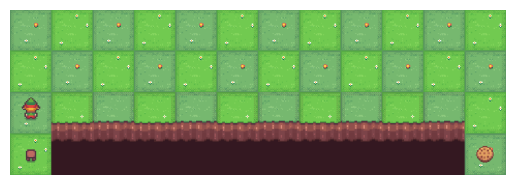

In [23]:
G, nb_actions = random_strategy.play(1, replay=True)
random_strategy.replay(max_frame=50)

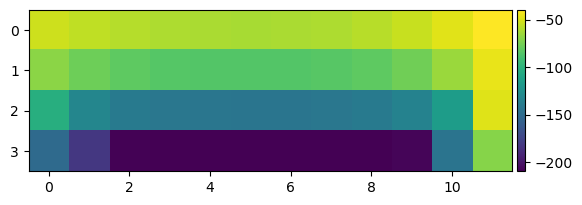

In [24]:
random_strategy.computeQpolVpol(.01)
plot_V_pol(random_strategy)

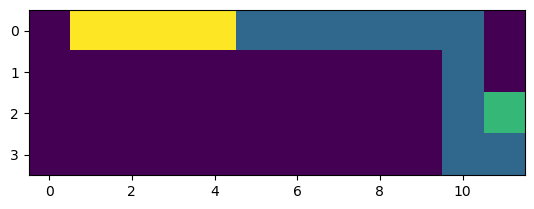

In [25]:
plot_optia_pol(random_strategy)

## A Classical RL Algoithm in Action

### A SARSA agent

In [26]:
class SarsaAgent(Agent):
    def __init__(self, env, pol=None, Q=None, gamma=.9, stepsize=.1, epsilon_init=1, epsilon_min=.01, epsilon_decay=.99):
        super().__init__(env, pol, Q, gamma)
        self.stepsize = stepsize
        self.epsilon_init = epsilon_init
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def learn_select_action(self):
        return(self.select_action(self.epsilon))

    def learn_init(self):
        self.epsilon = self.epsilon_init

    def learn_update_after_action(self):
        state = self.memory[self.t - 1]['state']
        action = self.memory[self.t - 1]['action']
        done = self.memory[self.t - 1]['done']
        new_state =  self.memory[self.t]['state']
        new_reward = self.memory[self.t]['reward']
        new_action = self.memory[self.t]['action']
        new_done = self.memory[self.t]['done']
        if done or new_done:
            self.Q[state, action] += self.stepsize * (
                new_reward - self.Q[state, action]
            )
        else:
            self.Q[state, action] += self.stepsize * (
                new_reward + self.gamma * self.Q[new_state, new_action] - self.Q[state, action]
            )
        self.update_state_pol(state)

    def learn_update_after_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def learn_final_update(self):
        self.update_pol()   
    

### In action

In [27]:
nb_learn_episodes = 1000
sarsa_strategy = SarsaAgent(env)
sarsa_strategy.learn(nb_learn_episodes)
G, nb_actions = sarsa_strategy.play(nb_play_episodes)
G / nb_actions

50  /  50


-1.0

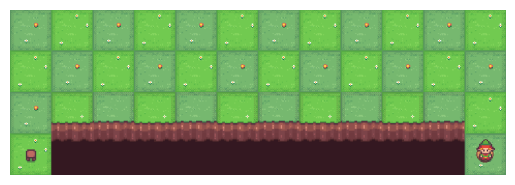

In [28]:
G, nb_actions = sarsa_strategy.play(1, replay=True)
sarsa_strategy.replay(max_frame=50)


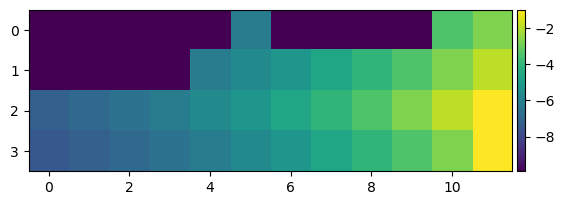

In [29]:
sarsa_strategy.computeQpolVpol(.01)
plot_V_pol(sarsa_strategy)


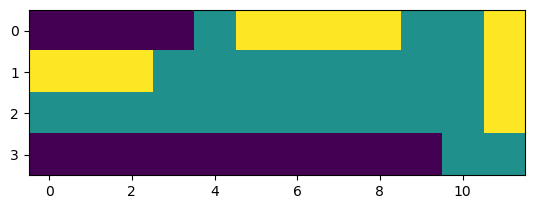

In [30]:
plot_optia_pol(sarsa_strategy)

## MDP Approach

### A MDP "agent" (which does not play)

In [31]:
class DPAgent(Agent):
    def __init__(self, env, pol=None, Q=None, gamma=.9):
        super().__init__(env, pol, Q)
        self.gamma = gamma

    def Optimal_Bellman_operator(self, Q):
        newQ = Q.copy()
        for state in range(self.env.observation_space.n):
                for action in range(self.env.action_space.n):
                    newQ[state, action] = 0
                    for prob, next_state, reward, done in self.env.P[state][action]:
                        if done:
                            newQ[state, action] += prob * reward
                        else:
                            newQ[state, action] += prob * (reward + self.gamma * np.max(Q[next_state, ]))
        return(newQ)

    def learn(self, epsi):
        delta = 2 * epsi
        while delta > epsi:
            delta = 0
            newQ = self.Optimal_Bellman_operator(self.Q)
            delta = np.max(np.abs(newQ - self.Q))
            self.Q = newQ
        self.update_pol()                    

### MDP Estimation of the Optimal Policy

In [32]:
DP_strategy = DPAgent(env)
DP_strategy.learn(0.01)
G, nb_actions = DP_strategy.play(nb_play_episodes)
G / nb_actions

50  /  50


-1.0

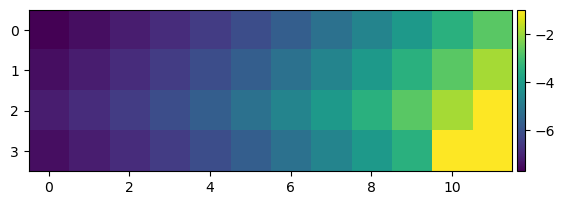

In [33]:
DP_strategy.computeQpolVpol(.01)
plot_V_pol(DP_strategy)

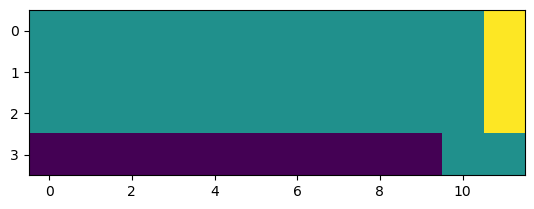

In [34]:
plot_optia_pol(DP_strategy)

## The most classical Agent : Q-learning

### The Classical Q-Learning Agent

In [35]:
class ClassicalQAgent(Agent):
    def __init__(self, env, pol=None, Q=None, gamma=.9, stepsize=.1, epsilon_init=1, epsilon_min=.01, epsilon_decay=.99):
        super().__init__(env, pol, Q)
        self.gamma = gamma
        self.stepsize = stepsize
        self.epsilon_init = epsilon_init
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def learn_select_action(self):
        return(self.select_action(self.epsilon))

    def learn_init(self):
        self.epsilon = self.epsilon_init

    def learn_update_after_action(self):
        state = self.memory[self.t - 1]['state']
        action = self.memory[self.t - 1]['action']
        done = self.memory[self.t - 1]['done']
        new_state =  self.memory[self.t]['state']
        new_reward = self.memory[self.t]['reward']
        new_done = self.memory[self.t]['done']

        if done or new_done:
            self.Q[state, action] += self.stepsize * (
                new_reward - self.Q[state, action]
            )
        else:
            self.Q[state, action] += self.stepsize * (
                new_reward + self.gamma * np.max(self.Q[new_state,]) - self.Q[state, action]
            )
        self.update_state_pol(state)

    def learn_update_after_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def learn_final_update(self):
        self.update_pol()

    

### In action...

In [36]:
classicalqlearning_strategy = ClassicalQAgent(env)
classicalqlearning_strategy.learn(nb_learn_episodes)
G, nb_actions = classicalqlearning_strategy.play(nb_play_episodes, replay=True)
G / nb_actions

50  /  50


-1.0

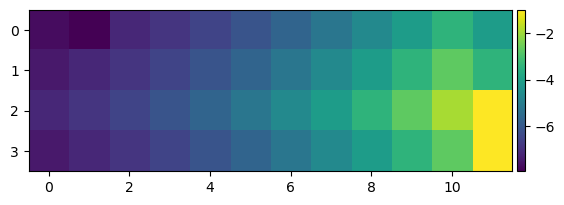

In [39]:
classicalqlearning_strategy.computeQpolVpol(.01)
plot_V_pol(classicalqlearning_strategy)

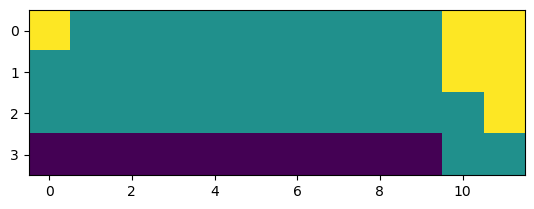

In [40]:
plot_optia_pol(classicalqlearning_strategy)

### An agent which learns while playing a random strategy (offline learning)

In [41]:
class QAgent(Agent):
    def __init__(self, env, pol=None, Q=None, gamma=.9, stepsize=.1):
        super().__init__(env, pol, Q)
        self.gamma = gamma
        self.stepsize = stepsize

    def learn_update_after_action(self):
        state = self.memory[self.t - 1]['state']
        action = self.memory[self.t - 1]['action']
        done = self.memory[self.t-1]['done']
        new_state =  self.memory[self.t]['state']
        new_reward = self.memory[self.t]['reward']
        new_done = self.memory[self.t-1]['done']

        if done or new_done:
            self.Q[state, action] += self.stepsize * (
                new_reward - self.Q[state, action]
            )
        else:
            self.Q[state, action] += self.stepsize * (
                new_reward + self.gamma * np.max(self.Q[new_state,]) - self.Q[state, action]
            )

    def learn_final_update(self):
        self.update_pol()

    

In [44]:
qlearning_strategy = QAgent(env)
qlearning_strategy.learn(nb_learn_episodes//3)
G, nb_actions = qlearning_strategy.play(nb_play_episodes, replay=True)
G / nb_actions

50  /  50


-1.0

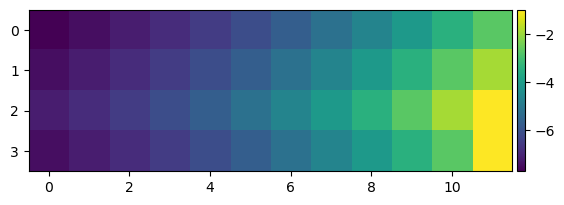

In [45]:
qlearning_strategy.computeQpolVpol(.01)
plot_V_pol(qlearning_strategy)

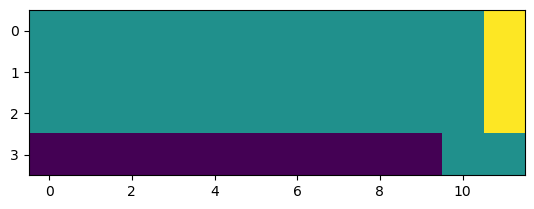

In [46]:
plot_optia_pol(qlearning_strategy)

## A Policy Based Approach

### A Policy Gradient Agent (in Jax)

In [47]:

import jax.numpy as jnp
import jax
jax.config.update('jax_platform_name', 'gpu')

@jax.jit
def jax_softmax(W):
    Wmax = jnp.max(W)
    sf = jnp.exp(W-Wmax)
    return(sf/sf.sum())

@jax.jit
def jax_logsoftmax(W):
    return(jnp.log(jax_softmax(W)))

@jax.jit
def jax_logsoftmax_coord(W, coord):
    return(jax_logsoftmax(W)[coord])

@jax.jit
def jax_jac_logsoftmax(W, coord):
    return(jax.jacfwd(jax_logsoftmax_coord)(W, coord))

@jax.jit
def jax_grad_logsoftmax_coord(W, coord):
    return(jax.grad(jax_logsoftmax_coord)(W, coord))

jax.jit(jax_softmax)(jnp.array([1.0,2.0,3]))
jax_grad_logsoftmax_coord(jnp.array([1.0,2,3]), 0)

DeviceArray([ 0.90996945, -0.24472849, -0.66524094], dtype=float32)

In [48]:
class AC(Agent):
    def __init__(self, env, pol=None, Q=None, gamma=.9, stepsize=.1, policy_stepsize=.05):
        super().__init__(env, pol, Q)
        self.gamma = gamma
        self.stepsize = stepsize
        self.W = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.policy_stepsize = policy_stepsize
        self.epsilon = 0

    def reset_pol(self, pol=None):
        """Restore the policity to the default uniform one or fix it to a specified one"""
        if pol is None:
            self.W = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.pol = self.update_pol()
        else:
            self.pol = pol

    def update_state_pol(self, state):
        """Perform a policy improvement step for a given state"""
        self.pol[state,] = jax.jit(jax_softmax)(self.W[state,])
        self.pol[state,] /=  self.pol[state,].sum()
 
    def learn_update_after_action(self):
        state = self.memory[self.t - 1]['state']
        action = self.memory[self.t - 1]['action']
        done = self.memory[self.t - 1]['done']
        new_state =  self.memory[self.t]['state']
        new_reward = self.memory[self.t]['reward']
        new_action = self.memory[self.t]['action']
        new_done = self.memory[self.t]['done']
        if done or new_done:
            delta_t = new_reward - self.Q[state, action]
        else:
            delta_t = new_reward + self.gamma * self.Q[new_state, new_action] - self.Q[state, action]
        self.W[state, ] += self.policy_stepsize * (self.Q[state, action] - np.dot(self.pol[state,], self.Q[state,])) \
                * jax_grad_logsoftmax_coord(self.W[state, ], action)
        self.Q[state, action] += self.stepsize * delta_t
        self.update_state_pol(state) 

## In action

In [51]:
ac_strategy = AC(env)
ac_strategy.learn(nb_learn_episodes)
G, nb_actions = ac_strategy.play(nb_play_episodes)
G / nb_actions

50  /  50


-1.0

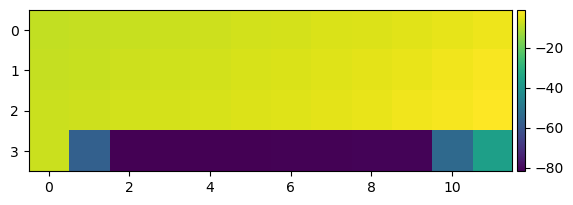

In [52]:
ac_strategy.computeQpolVpol(.01)
plot_V_pol(ac_strategy)


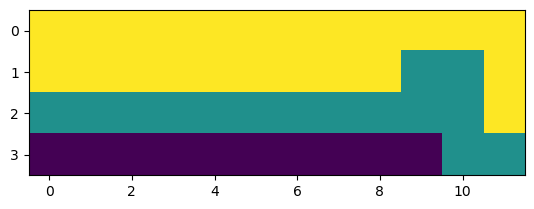

In [53]:
plot_optia_pol(ac_strategy)